# Lectura de datos

Comenzamos con el dataset entregado en la **PRA1**

In [4]:
import pandas as pd
df=pd.read_excel('preciosEESS_es.xls', header=3)
df.describe()



,Código postal,% bioalcohol,% éster metílico,Precio metanol\t
count,12032.000000,0.0,0.0,0.0
mean,25413.092836,NaN,NaN,NaN
std,14430.123110,NaN,NaN,NaN
min,1002.000000,NaN,NaN,NaN
25%,12100.000000,NaN,NaN,NaN
50%,27298.000000,NaN,NaN,NaN
75%,37700.000000,NaN,NaN,NaN
max,52006.000000,NaN,NaN,NaN


## 1.1 Ajuste de datos numéricos

In [5]:
col_withprecio = [c for c in df.columns if 'precio' in c.lower() or 'longitud' in c.lower() or 'latitud' in c.lower()]
for col in col_withprecio:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12032 entries, 0 to 12031
Data columns (total 40 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Provincia                           12032 non-null  object 
 1   Municipio                           12032 non-null  object 
 2   Localidad                           12032 non-null  object 
 3   Código postal                       12032 non-null  int64  
 4   Dirección                           12032 non-null  object 
 5   Margen                              12032 non-null  object 
 6   Longitud                            12032 non-null  float64
 7   Latitud                             12032 non-null  float64
 8   Toma de datos                       12032 non-null  object 
 9   Precio gasolina 95 E5               10905 non-null  float64
 10  Precio gasolina 95 E10              33 non-null     float64
 11  Precio gasolina 95 E5 Premium       1051 

Ajustamos los outliers con Latitud y Longitud intercambiadas

In [6]:
filtro_intercambiadas = (df['Latitud'].between(-19, 5)) & (df['Longitud'].between(27, 44))
print(f"Detectadas {filtro_intercambiadas.sum()} filas con coordenadas intercambiadas.")
df.loc[filtro_intercambiadas, ['Latitud', 'Longitud']] = \
    df.loc[filtro_intercambiadas, ['Longitud', 'Latitud']].values
casos_restantes = ((df['Latitud'].between(-19, 5)) & (df['Longitud'].between(27, 44))).sum()
print(f"Casos pendientes tras la corrección: {casos_restantes}")

Detectadas 1 filas con coordenadas intercambiadas.
Casos pendientes tras la corrección: 0


## 1.2 Ajuste de columnas con CP

In [7]:
#Convertimos a 5 dígitos el CP
df['Código postal'] = pd.to_numeric(df['Código postal'], errors='coerce').astype(int).astype(str).str.zfill(5)
df['Ultimo dato'] = pd.to_datetime(df['Toma de datos'], format='%d/%m/%Y %H:%M').dt.date
df['Rótulo'].value_counts().head(30)

Rótulo
REPSOL         2724
CEPSA           667
MOEVE           496
GALP            449
BALLENOIL       355
SHELL           337
PLENERGY        336
PETROPRIX       169
PETRONOR        157
CARREFOUR       147
BP              142
AVIA            109
Q8               89
BONAREA          66
ESCLATOIL        65
CAMPSA           59
VALCARCE         48
AGLA             47
ALCAMPO          45
EROSKI           40
ENI              39
HAM              39
MEROIL           37
GASEXPRESS       36
BEROIL           31
TAMOIL           30
MOLGAS           27
IDS              23
COOPERATIVA      23
DISA             23
Name: count, dtype: int64

## 1.3 Clasificación de gasolineras
Clasifica las gasolineras según la marca del vendedor:
- Gran petrolera
- Supermercado
- Descuento
- Independiente

In [8]:
petroleras = ['REPSOL', 'CEPSA', 'MOEVE', 'BP', 'GALP', 'SHELL', 'PETRONOR', 'AVIA', 'CAMPSA', 'TOTAL', 'ENI', 'TAMOIL']
supermercados = ['ALCAMPO', 'CARREFOUR', 'E.LECLERC', 'BONAREA', 'EROSKI', 'FAMILY CASH', 'COSTCO', 'ESCLATOIL']
descuento = ['PLENOIL', 'BALLENOIL', 'PETROPRIX', 'GASEXPRESS', 'B-OIL', 'Q8', 'PLENERGY', 'VALCARCE', 'MEROIL', 'BEROIL', 
            'MOLGAS', 'IDS', 'HAM'] # OJO PQ ESTAS SON DE GAS
# 2. Función de clasificación
def clasificar_vendedor(rotulo):
    rotulo = str(rotulo).upper()
    
    if any(m in rotulo for m in petroleras):
        return 'Petrolera'
    elif any(m in rotulo for m in supermercados):
        return 'Supermercado'
    elif any(m in rotulo for m in descuento):
        return 'Descuento'
    else:
        # Si no encaja en las anteriores, se considera Independiente
        return 'Independiente'
# 3. Aplicamos la clasificación
df['Tipo_Vendedor'] = df['Rótulo'].apply(clasificar_vendedor)
# Verificamos la distribución
print(df['Tipo_Vendedor'].value_counts())
df[df['Tipo_Vendedor'] == 'Independiente']['Rótulo'].value_counts()

Tipo_Vendedor
Petrolera        6057
Independiente    4333
Descuento        1249
Supermercado      393
Name: count, dtype: int64


Rótulo
AGLA                                         47
DISA                                         23
COOPERATIVA                                  23
CEREALES TERUEL                              21
NIEVES                                       20
                                             ..
APROVISIONAMIENTOS JIMENEZ ZARAGOZA           1
COOP.AGR. NTRA. SEÑORA DEL NIÑO PERDIDO       1
AN ENERGETICOS S,L - SOS DEL REY CATOLICO     1
E.S.LA MUELA                                  1
COSANCLEMENTE                                 1
Name: count, Length: 3283, dtype: int64

## 1.4 Clasificación de provincias y CCAA a partir de los datos del INE y carga de población por provincia
Cargamos el fichero del INE -https://www.ine.es/dyngs/INEbase/es/operacion.htm?c=Estadistica_C&cid=1254736177031&menu=ultiDatos&idp=1254734710990- con el listado oficial de CCAA y Provincias.
También usamos el fichero del INE -https://www.ine.es/jaxiT3/Datos.htm?t=2852- con la población por provincia del año 2021 separada por Total, Hombres y Mujeres.

In [9]:
dfccaaprov = pd.read_csv('ccaa-prov-ine.csv', sep=';', dtype={'Cod_Provincia': str})
poblacionprov = pd.read_csv('poblacion-prov-ine.csv', sep=';', usecols=['Cod_Provincia', 'Total población', 'Población hombres', 'Población mujeres', 'Provincia'], dtype={'Cod_Provincia': str, 'Total población': float, 'Población hombres': float, 'Población mujeres': float, 'Provincia': str})
df['Cod_Provincia'] = df['Código postal'].str[:2]
df = df.merge(dfccaaprov[['Cod_Provincia', 'Provincia', 'Comunidad_Autonoma']], on='Cod_Provincia', how='left', suffixes=('', '_INE'))
df = df.merge(poblacionprov[['Cod_Provincia', 'Total población', 'Población hombres', 'Población mujeres']], on='Cod_Provincia', how='left', suffixes=('', '_INE'))
df.drop(columns=['Cod_Provincia', 'Provincia'], inplace=True)
df.rename(columns={'Provincia_INE': 'Provincia'}, inplace=True)
df.info()
print(df['Provincia'].unique())
print(df['Comunidad_Autonoma'].unique())
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12032 entries, 0 to 12031
Data columns (total 46 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Municipio                           12032 non-null  object 
 1   Localidad                           12032 non-null  object 
 2   Código postal                       12032 non-null  object 
 3   Dirección                           12032 non-null  object 
 4   Margen                              12032 non-null  object 
 5   Longitud                            12032 non-null  float64
 6   Latitud                             12032 non-null  float64
 7   Toma de datos                       12032 non-null  object 
 8   Precio gasolina 95 E5               10905 non-null  float64
 9   Precio gasolina 95 E10              33 non-null     float64
 10  Precio gasolina 95 E5 Premium       1051 non-null   float64
 11  Precio gasolina 98 E5               5564 

,Municipio,Localidad,Código postal,Dirección,Margen,Longitud,Latitud,Toma de datos,Precio gasolina 95 E5,Precio gasolina 95 E10,...,Rem.,Horario,Tipo servicio,Ultimo dato,Tipo_Vendedor,Provincia,Comunidad_Autonoma,Total población,Población hombres,Población mujeres
0,ABENGIBRE,ABENGIBRE,02250,"AVENIDA CASTILLA LA MANCHA, 26",D,-1.539167,39.211417,02/12/2025 11:36,1.399,NaN,...,dm,L-D: 07:00-22:00,L-D: 07:00-22:00 (A),2025-12-02,Independiente,Albacete,Castilla - La Mancha,386464.0,193205.0,193259.0
1,ALATOZ,ALATOZ,02152,"CR CM-332, 46,4",I,-1.346083,39.100389,01/12/2025 23:59,1.599,NaN,...,dm,L-D: 7:00-23:00,L-D: 7:00-23:00 (A),2025-12-01,Petrolera,Albacete,Castilla - La Mancha,386464.0,193205.0,193259.0
2,ALBACETE,ALBACETE,02001,"CALLE FEDERICO GARCIA LORCA, 1",D,-1.849833,39.000861,01/12/2025 04:15,1.359,NaN,...,dm,L-D: 24H,L-D: 24H (D),2025-12-01,Descuento,Albacete,Castilla - La Mancha,386464.0,193205.0,193259.0
3,ALBACETE,ALBACETE,02001,"CALLE FEDERICO GARCIA LORCA, 5",I,-1.846361,38.997722,01/12/2025 14:20,NaN,NaN,...,dm,L-S: 05:00-23:00,L-S: 05:00-23:00 (A),2025-12-01,Petrolera,Albacete,Castilla - La Mancha,386464.0,193205.0,193259.0
4,ALBACETE,ALBACETE,02001,"AVENIDA 1º DE MAYO, S/N",N,-1.868500,38.985667,03/12/2025 10:38,1.489,NaN,...,dm,L-S: 08:00-22:00; D: 09:00-21:00,L-S: 08:00-22:00 (A); D: 09:00-21:00 (A),2025-12-03,Supermercado,Albacete,Castilla - La Mancha,386464.0,193205.0,193259.0
5,ALBACETE,ALBACETE,02001,CALLE PRINCIPE DE ASTURIAS (POLÍGONO DE ROMICA...,I,-1.832000,39.054694,03/12/2025 00:00,1.509,NaN,...,OM,L-D: 06:00-22:00,L-D: 06:00-22:00 (P),2025-12-03,Petrolera,Albacete,Castilla - La Mancha,386464.0,193205.0,193259.0
6,ALBACETE,ALBACETE,02005,"AVENIDA MENÉNDEZ PIDAL, 58",N,-1.864917,39.003333,03/12/2025 12:32,1.509,NaN,...,dm,L: 05:00-01:00,L: 05:00-01:00 (A),2025-12-03,Independiente,Albacete,Castilla - La Mancha,386464.0,193205.0,193259.0
7,ALBACETE,ALBACETE,02005,"AVENIDA ESCRITOR RODRIGO RUBIO, 3",D,-1.885361,39.006889,30/11/2025 09:46,1.347,NaN,...,dm,L-S: 09:00-21:30,Sin datos,2025-11-30,Independiente,Albacete,Castilla - La Mancha,386464.0,193205.0,193259.0
8,ALBACETE,ALBACETE,02005,"CL PASEO DE LA CUBA, 15",D,-1.854556,38.999722,03/12/2025 00:00,1.529,NaN,...,OM,L-D: 06:00-22:00,L-D: 06:00-22:00 (A),2025-12-03,Petrolera,Albacete,Castilla - La Mancha,386464.0,193205.0,193259.0
9,ALBACETE,ALBACETE,02005,"PASEO CUBA (LA), 36",N,-1.859917,39.005083,03/12/2025 14:00,1.509,NaN,...,OM,L-D: 06:00-22:00,L-D: 06:00-22:00 (P),2025-12-03,Petrolera,Albacete,Castilla - La Mancha,386464.0,193205.0,193259.0


## 1.5 Puntos de suministro de combustibles de la red Española
La compañía EXOLUM es la encargada de suministrar combustibles a la red de gasolineras de la red Española. 
A partir de una red de almacenamiento directamente conectada a las refineries, se proporciona acceso a las empresas que venden los combustibles a los consumidores finales. 
La empresa vendedora añade los aditivos propios de la marca al combustible proporcionado por EXOLUM.
La distancia al punto de distribucción EXOLUM más cercano es la columna `Distancia_Exolum_lm`.
Señalamos los puntos de suministro de combustibles de la red Española. Para ello, marcamos las principales refinerías y depósitos de combustibles y ajustamos la distancia de cada gasolinera a los puntos de suministro más cercanos.
Creamos cuatro columnas con el nº de gasolineras alrededor de cada punto de suministro:
- `competencia_1km`: número de gasolineras a menos de 1 km de distancia
- `competencia_2km`: número de gasolineras a menos de 2 km de distancia
- `competencia_5km`: número de gasolineras a menos de 5 km de distancia
- `competencia_10km`: número de gasolineras a menos de 10 km de distancia
- `competencia_50km`: número de gasolineras a menos de 50 km de distancia
- `competencia_100km`: número de gasolineras a menos de 100 km de distancia

In [10]:
from sklearn.neighbors import BallTree
import numpy as np
df_exolum=pd.read_csv('exolum.csv', sep=';')
df_exolum.drop(['Instalacion', 'Provincia'], axis=1, inplace=True)
tree_exolum = BallTree(np.deg2rad(df_exolum[['Latitud', 'Longitud']]).values, metric='haversine')

print(df_exolum.head(10))
df_geo=df[['Latitud', 'Longitud']].copy()
coords = np.deg2rad(df_geo.values)
tree = BallTree(coords, metric='haversine') 
radio_tierra_km = 6371
radio_radianes1km = 1 / radio_tierra_km
radio_radianes10km = 10 / radio_tierra_km
radio_radianes25km = 25 / radio_tierra_km
for km in [1, 2, 5, 10, 25, 50, 100]:
  radio_radianes = km / radio_tierra_km
  counts = tree.query_radius(coords, r=radio_radianes, count_only=True)
  df[f'Competencia_{km}km'] = counts -1;

# Distancia a EXOLUM más cercano
distancia_exolum_rad, indices = tree_exolum.query(coords, k=1)
df['Distancia_Exolum_km'] = distancia_exolum_rad.flatten() * radio_tierra_km

df.tail(10)
#df[columnas_km] = df_geo[columnas_km]
#print(f'{df_geo['Competencia_10km'].mean():.2f}')


   Latitud  Longitud
0  36.1822   -5.4014
1  38.3125   -0.5114
2  36.8314   -2.4419
3  37.2628   -5.5414
4  38.8814   -6.9711
5  41.3325    2.1514
6  39.9611   -0.0214
7  37.9125   -4.7511
8  43.5514   -5.6914
9  37.2114   -6.9314


,Municipio,Localidad,Código postal,Dirección,Margen,Longitud,Latitud,Toma de datos,Precio gasolina 95 E5,Precio gasolina 95 E10,...,Población hombres,Población mujeres,Competencia_1km,Competencia_2km,Competencia_5km,Competencia_10km,Competencia_25km,Competencia_50km,Competencia_100km,Distancia_Exolum_km
12022,ZARAGOZA,VILLARRAPA,50692,"AUTOVIA A-68 KM. 258,25",D,-1.078944,41.740389,03/12/2025 00:00,1.549,NaN,...,473354.0,494098.0,2,4,8,19,123,214,459,14.493267
12023,ZARAGOZA,ZARAGOZA,50197,"AVENIDA DIAGONAL PLAZA, 22",D,-0.990111,41.636528,03/12/2025 08:28,1.539,NaN,...,473354.0,494098.0,5,8,16,56,127,198,450,3.616865
12024,ZARAGOZA,ZARAGOZA,50197,"AVENIDA DIAGONAL, 19",D,-0.992556,41.638639,03/12/2025 11:00,1.349,NaN,...,473354.0,494098.0,5,8,16,55,127,198,449,3.702485
12025,ZARAGOZA,ZARAGOZA,50197,"RONDA FERIA DE MUESTRAS, DE LA, 20",D,-0.986389,41.637944,03/12/2025 00:00,NaN,NaN,...,473354.0,494098.0,6,8,17,57,131,198,450,3.269789
12026,ZARAGOZA,ZARAGOZA,50197,"POLIGONO CALLE TURIASO, 31",D,-0.974194,41.645722,02/12/2025 16:53,NaN,NaN,...,473354.0,494098.0,2,8,24,66,128,198,453,1.996390
12027,ZARAGOZA,ZARAGOZA,50197,"RONDA RONDA DE LA FERIA DE MUESTRAS, 10",D,-0.987833,41.638361,01/12/2025 12:17,NaN,NaN,...,473354.0,494098.0,6,8,17,56,129,198,450,3.356627
12028,ZARAGOZA,ZARAGOZA,50197,"CALLE ISLA DE PANTELARIA, 38",N,-0.977472,41.637639,01/12/2025 10:21,1.421,NaN,...,473354.0,494098.0,4,8,21,62,129,199,452,2.652314
12029,ZUERA,ZUERA,50800,"CALLE AUSTRIA, 11,17",D,-0.782833,41.883583,02/12/2025 15:17,1.434,NaN,...,473354.0,494098.0,0,0,1,3,36,203,469,29.359670
12030,ZUERA,ZUERA,50800,"CARRETERA N-330A KM. 24,000",D,-0.794000,41.857000,03/12/2025 00:00,1.529,NaN,...,473354.0,494098.0,0,0,2,5,63,207,464,26.327421
12031,ZUERA,ONTINAR DE SALZ,50810,"CALLE COOPERATIVA, 2",D,-0.757611,41.938750,03/12/2025 09:47,1.434,NaN,...,473354.0,494098.0,0,0,0,3,20,199,470,35.763169


**Fijamos el nivel de competencia en 2km**:
- 0: Sin competencia
- 1 ó 2: Baja
- Más de 2 y menos de 7: Media
- Más de 7: Alta

In [11]:
bins = [-1, 0, 2, 7, float('inf')]
labels = ['Sin competencia', 'Baja', 'Media', 'Alta']
df['Nivel_Competencia'] = pd.cut(df['Competencia_2km'], bins=bins, labels=labels)
# Verificamos la distribución de los nuevos niveles
print(df['Nivel_Competencia'].value_counts())

Nivel_Competencia
Media              3456
Baja               3334
Alta               2665
Sin competencia    2577
Name: count, dtype: int64


## 1.6 Valores medios en los datos agregados por provincia y comunidad autónoma


In [12]:
# Lista de combustibles para calcular promedios
fuels = ['Precio gasóleo A', 'Precio gasolina 95 E5', 'Precio AdBlue']
for fuel in fuels:
    # Creamos nombres de columnas descriptivos
    col_prov = f'Precio_Medio_{fuel.split(" ")[1]}_{fuel.split(" ")[2] if len(fuel.split(" "))>2 else ""}_Provincia'.replace("__", "_")
    col_ccaa = f'Precio_Medio_{fuel.split(" ")[1]}_{fuel.split(" ")[2] if len(fuel.split(" "))>2 else ""}_CCAA'.replace("__", "_")
    
    # Simplificamos los nombres para que sean más legibles
    if "gasóleo" in fuel.lower(): name = "GasoleoA"
    elif "gasolina" in fuel.lower(): name = "Gasolina95"
    else: name = "AdBlue"
    
    df[f'PrecioMedio_{name}_Prov'] = df.groupby('Provincia')[fuel].transform('mean')
    df[f'PrecioMedio_{name}_CCAA'] = df.groupby('Comunidad_Autonoma')[fuel].transform('mean')
# Ejemplo de visualización de las nuevas columnas
df[['Provincia', 'Precio gasóleo A', 'PrecioMedio_GasoleoA_Prov', 'PrecioMedio_GasoleoA_CCAA']].head()

,Provincia,Precio gasóleo A,PrecioMedio_GasoleoA_Prov,PrecioMedio_GasoleoA_CCAA
0,Albacete,1.399,1.439645,1.434606
1,Albacete,1.559,1.439645,1.434606
2,Albacete,1.325,1.439645,1.434606
3,Albacete,1.499,1.439645,1.434606
4,Albacete,1.429,1.439645,1.434606


## 1.7 Regimenes fiscales especiales
Marcamos las gasolineras que pertenecen a los regimenes fiscales especiales

In [13]:
# Lista de CC.AA. con régimen fiscal especial
ccaa_especiales = ['Canarias', 'Ceuta, Ciudad Autónoma de', 'Melilla, Ciudad Autónoma de']
# Creamos la columna binaria (1 si es especial, 0 si es régimen común)
df['Regimen_Fiscal_Especial'] = df['Comunidad_Autonoma'].isin(ccaa_especiales).astype(int)
# Verificamos cuántas gasolineras hay en cada régimen
print(df['Regimen_Fiscal_Especial'].value_counts())

Regimen_Fiscal_Especial
0    11519
1      513
Name: count, dtype: int64


## 1.8 Guardamos los dataset resultantes en un archivo CSV
- `practica2-medidas.csv`: Medidas a estudiar
- `practica2-hechos.csv`: Hechos

In [14]:
df.to_csv('practica2-datos.csv', sep=';', index=False)

## 2 Visualización de datos
Visualizamos los datos de los que disponemos, comenzamos por el nº de gasolineras en cada Comunidad Autónoma.

C:\Users\Pedro\AppData\Local\Temp\ipykernel_25116\3312424103.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


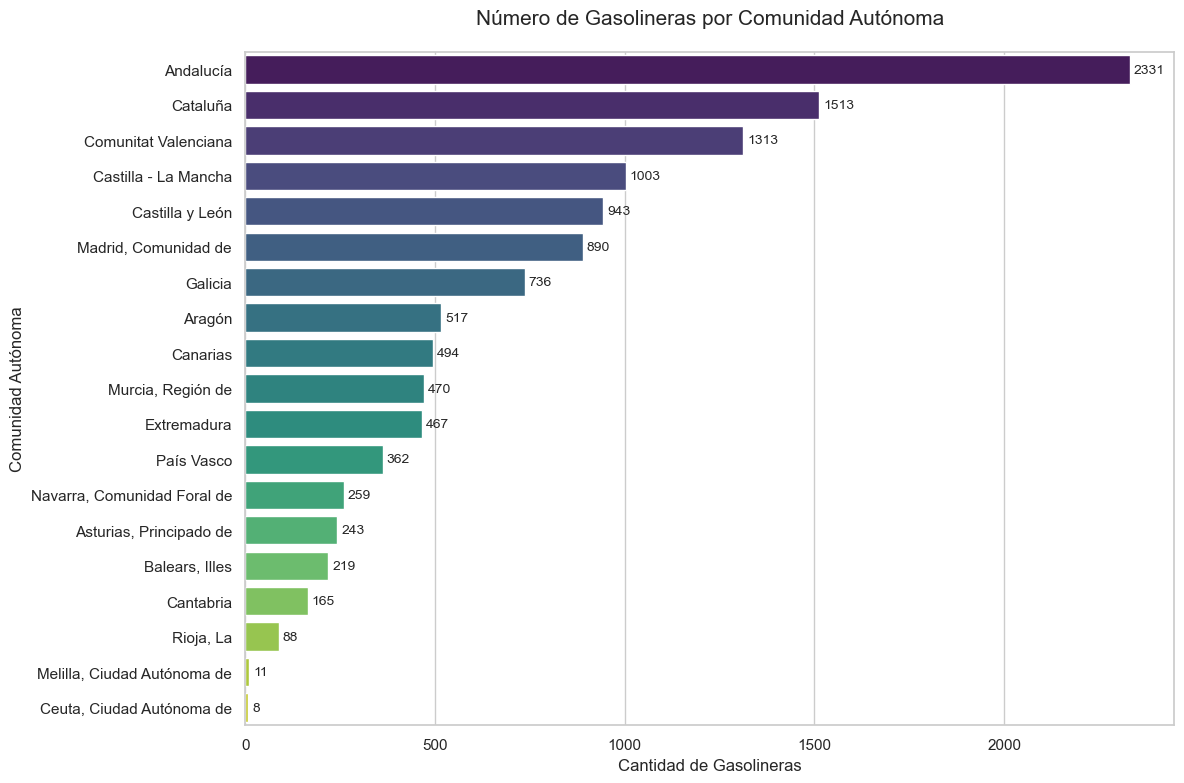

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
# Configuramos el estilo visual
sns.set_theme(style="whitegrid")
# Creamos la figura
plt.figure(figsize=(12, 8))
# Calculamos el orden de mayor a menor
order = df['Comunidad_Autonoma'].value_counts().index
# Generamos el gráfico de barras horizontales
sns.countplot(
    data=df, 
    y='Comunidad_Autonoma', 
    order=order, 
    palette='viridis'
)
# Añadimos etiquetas y título
plt.title('Número de Gasolineras por Comunidad Autónoma', fontsize=15, pad=20)
plt.xlabel('Cantidad de Gasolineras', fontsize=12)
plt.ylabel('Comunidad Autónoma', fontsize=12)
# Añadimos los valores exactos al final de cada barra para mayor claridad
for i, count in enumerate(df['Comunidad_Autonoma'].value_counts()):
    plt.text(count + 10, i, str(count), va='center', fontsize=10)
plt.tight_layout()
plt.show()

## 2.1 Distribución de precio de los combustibles por Comunidades Autónomas
Mediante gráficos de tipo Min/Max vemos el rango de precios de cada combustible en cada Comunidad Autónoma.

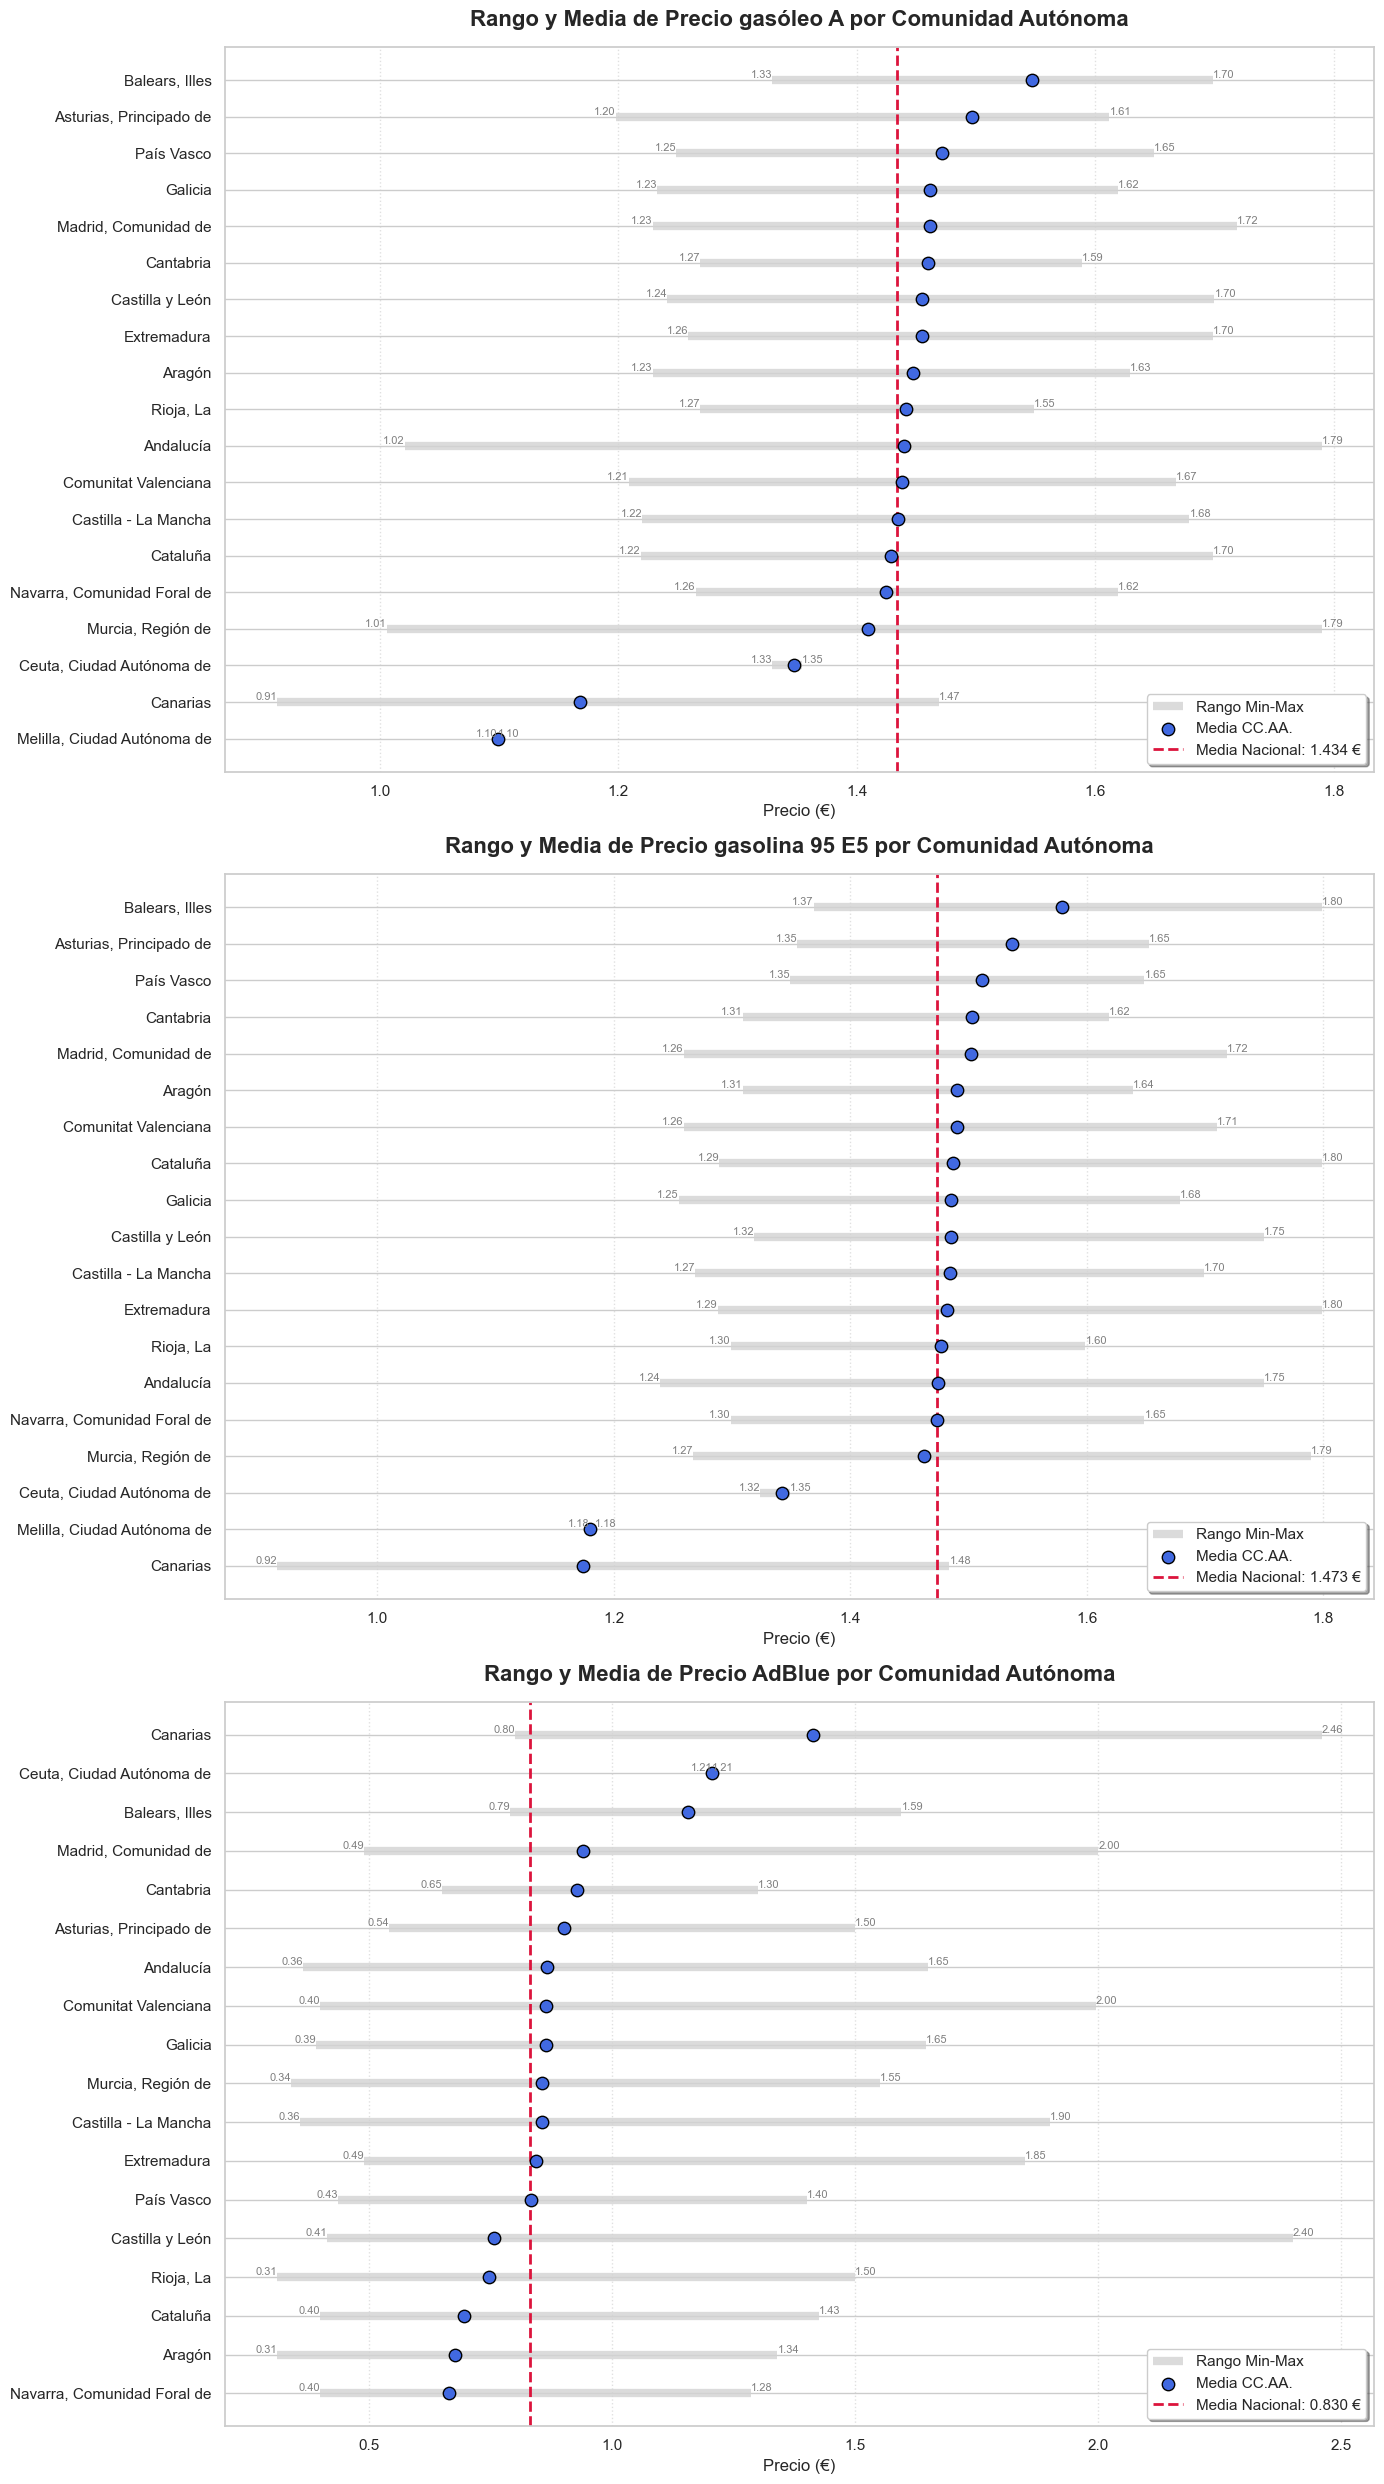

In [16]:
# Lista de combustibles
fuels = ['Precio gasóleo A', 'Precio gasolina 95 E5', 'Precio AdBlue']
# Creamos la figura con 3 subgráficos
fig, axes = plt.subplots(3, 1, figsize=(14, 25))
for i, fuel in enumerate(fuels):
    # 1. Calculamos estadísticas por CC.AA.
    stats = df.groupby('Comunidad_Autonoma')[fuel].agg(['mean', 'min', 'max']).sort_values('mean')
    national_avg = df[fuel].mean()
    
    # 2. Dibujamos las bandas (Min a Max)
    axes[i].hlines(y=stats.index, xmin=stats['min'], xmax=stats['max'], 
                   color='lightgray', linewidth=6, alpha=0.8, label='Rango Min-Max')
    
    # 3. Dibujamos los puntos de la media regional
    axes[i].scatter(stats['mean'], stats.index, color='royalblue', s=80, 
                    label='Media CC.AA.', zorder=3, edgecolor='black')
    
    # 4. Añadimos la línea de la media nacional
    axes[i].axvline(national_avg, color='crimson', linestyle='--', linewidth=2, 
                    label=f'Media Nacional: {national_avg:.3f} €')
    
    # 5. Configuración estética
    axes[i].set_title(f'Rango y Media de {fuel} por Comunidad Autónoma', fontsize=16, fontweight='bold', pad=15)
    axes[i].set_xlabel('Precio (€)', fontsize=12)
    axes[i].grid(axis='x', linestyle=':', alpha=0.6)
    axes[i].legend(loc='lower right', frameon=True, shadow=True)
    
    # Añadimos etiquetas para Min, Max y Mean en la primera línea para guiar al usuario
    for idx, (ccaa, row) in enumerate(stats.iterrows()):
        axes[i].text(row['min'], idx, f"{row['min']:.2f}", va='bottom', ha='right', fontsize=8, color='gray')
        axes[i].text(row['max'], idx, f"{row['max']:.2f}", va='bottom', ha='left', fontsize=8, color='gray')
plt.tight_layout()
plt.show()

C:\Users\Pedro\AppData\Local\Temp\ipykernel_25116\2532250368.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\Pedro\AppData\Local\Temp\ipykernel_25116\2532250368.py:19: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
C:\Users\Pedro\AppData\Local\Temp\ipykernel_25116\2532250368.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\Pedro\AppData\Local\Temp\ipykernel_25116\2532250368.py:19: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


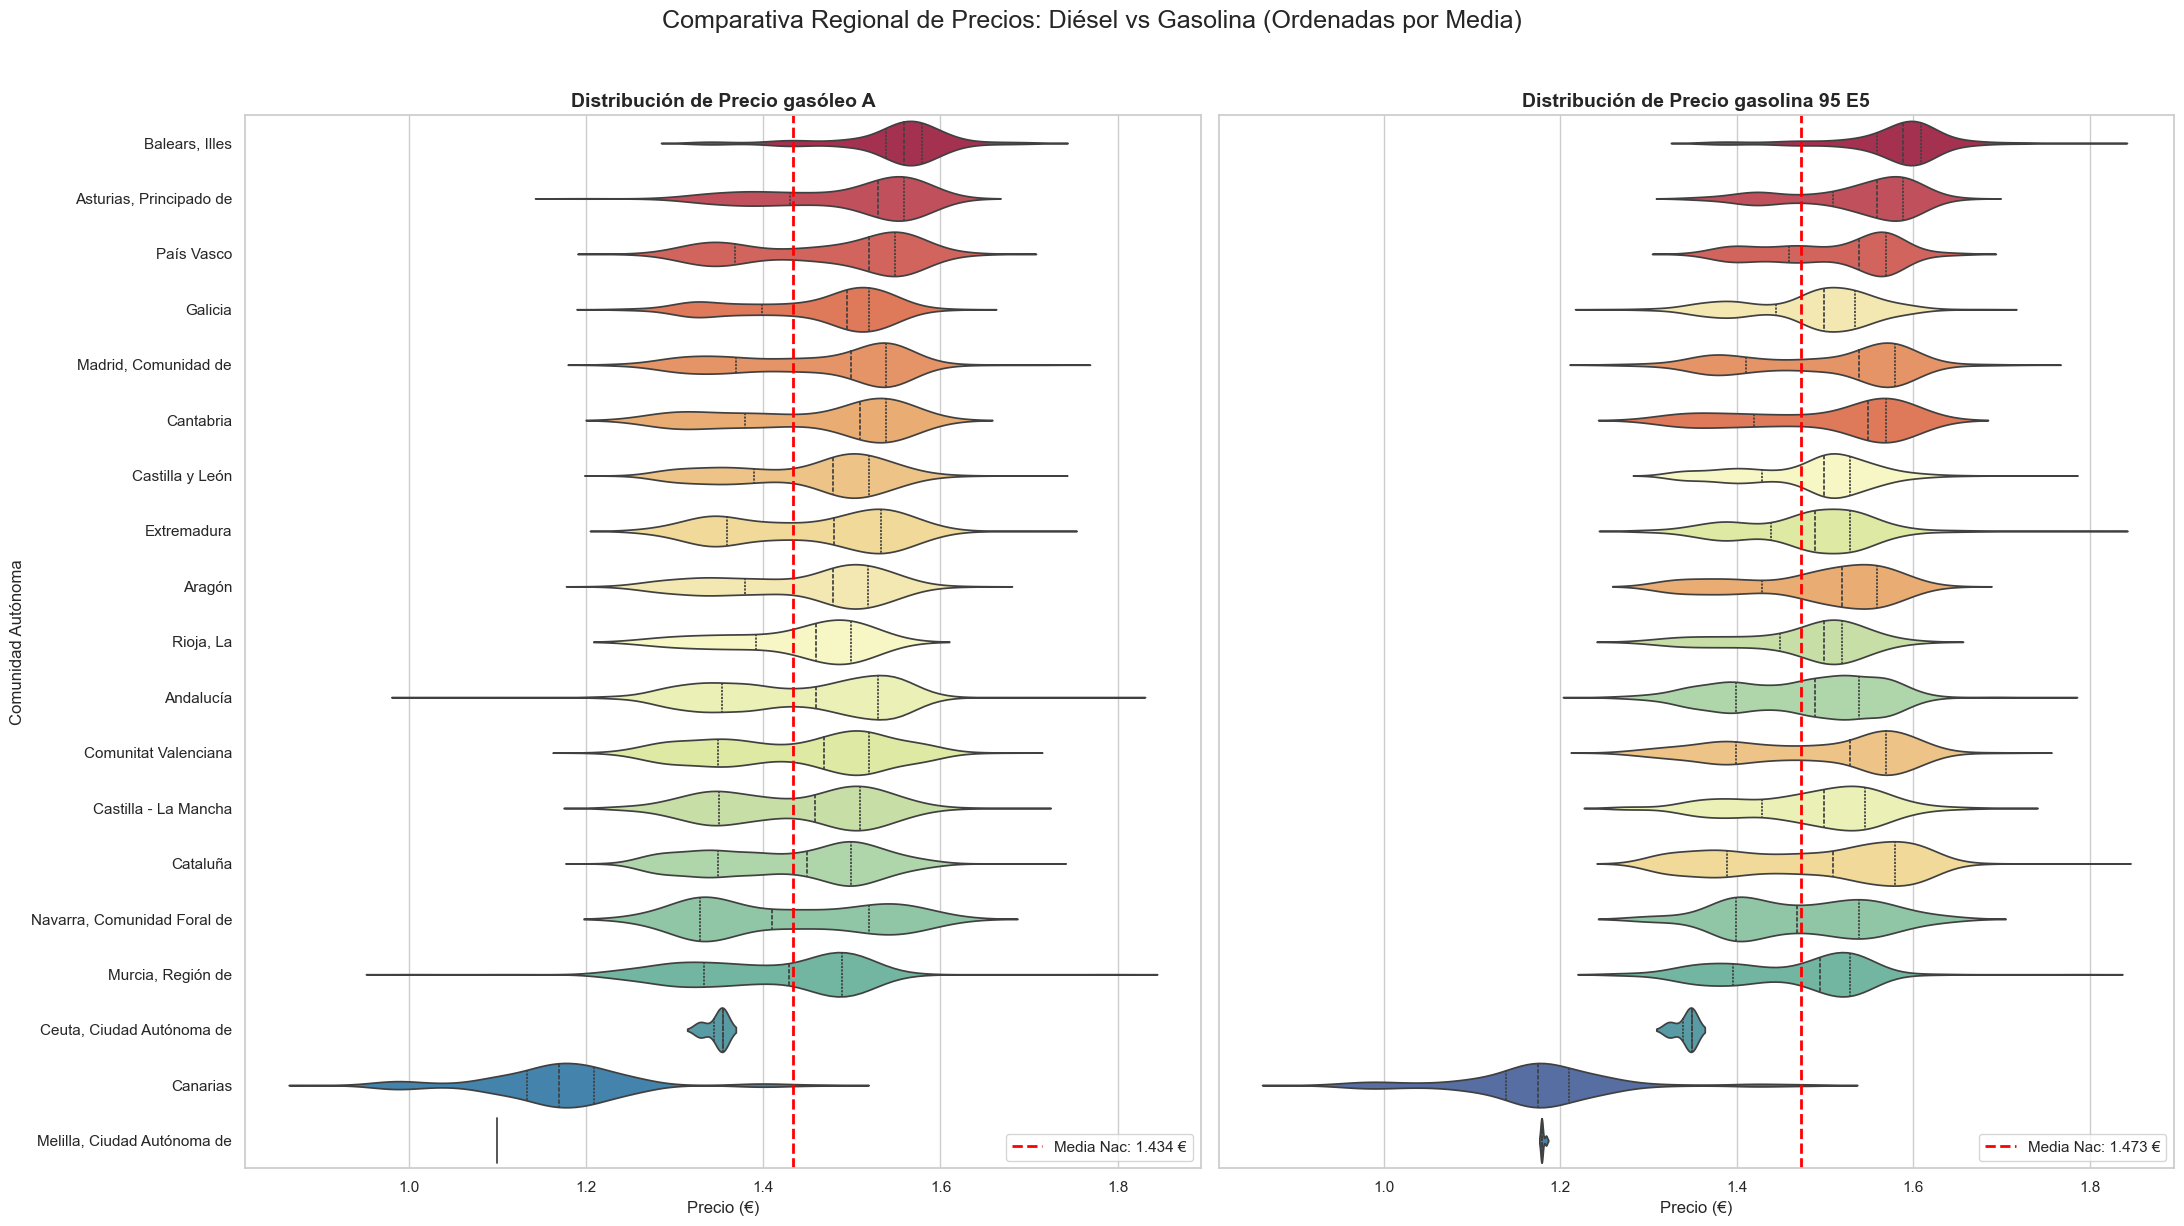

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Estilo y combustibles
sns.set_theme(style="whitegrid")
combustibles = ['Precio gasóleo A', 'Precio gasolina 95 E5']

# 2. Creamos la figura con 2 subplots (1 fila, 2 columnas)
# sharey=True para que las CC.AA. estén alineadas perfectamente
fig, axes = plt.subplots(1, 2, figsize=(22, 12), sharey=True)

for i, fuel in enumerate(combustibles):
    ax = axes[i]
    
    # Calculamos el orden (de mayor a menor) específico para ESTE combustible
    orden_ca = df.groupby('Comunidad_Autonoma')[fuel].mean().sort_values(ascending=False).index
    
    # Gráfico de violín
    sns.violinplot(
        data=df, y='Comunidad_Autonoma', x=fuel, 
        order=orden_ca, # <--- Ordenación dinámica
        palette='Spectral', inner='quartile', scale='width', ax=ax
    )
    
    # Media nacional como referencia
    national_avg = df[fuel].mean()
    ax.axvline(national_avg, color='red', linestyle='--', linewidth=2, 
               label=f'Media Nac: {national_avg:.3f} €')
    
    ax.set_title(f'Distribución de {fuel}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Precio (€)', fontsize=12)
    ax.set_ylabel('Comunidad Autónoma' if i == 0 else '', fontsize=12)
    ax.legend(loc='lower right')

plt.suptitle('Comparativa Regional de Precios: Diésel vs Gasolina (Ordenadas por Media)', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

### 2.1.2 ¿Influye la Despoblación en el Precio? (Diésel vs Gasolina)'

Observamos como el precio de los combustibles no se ve particularmente impactado por la densidad de población del territorio.


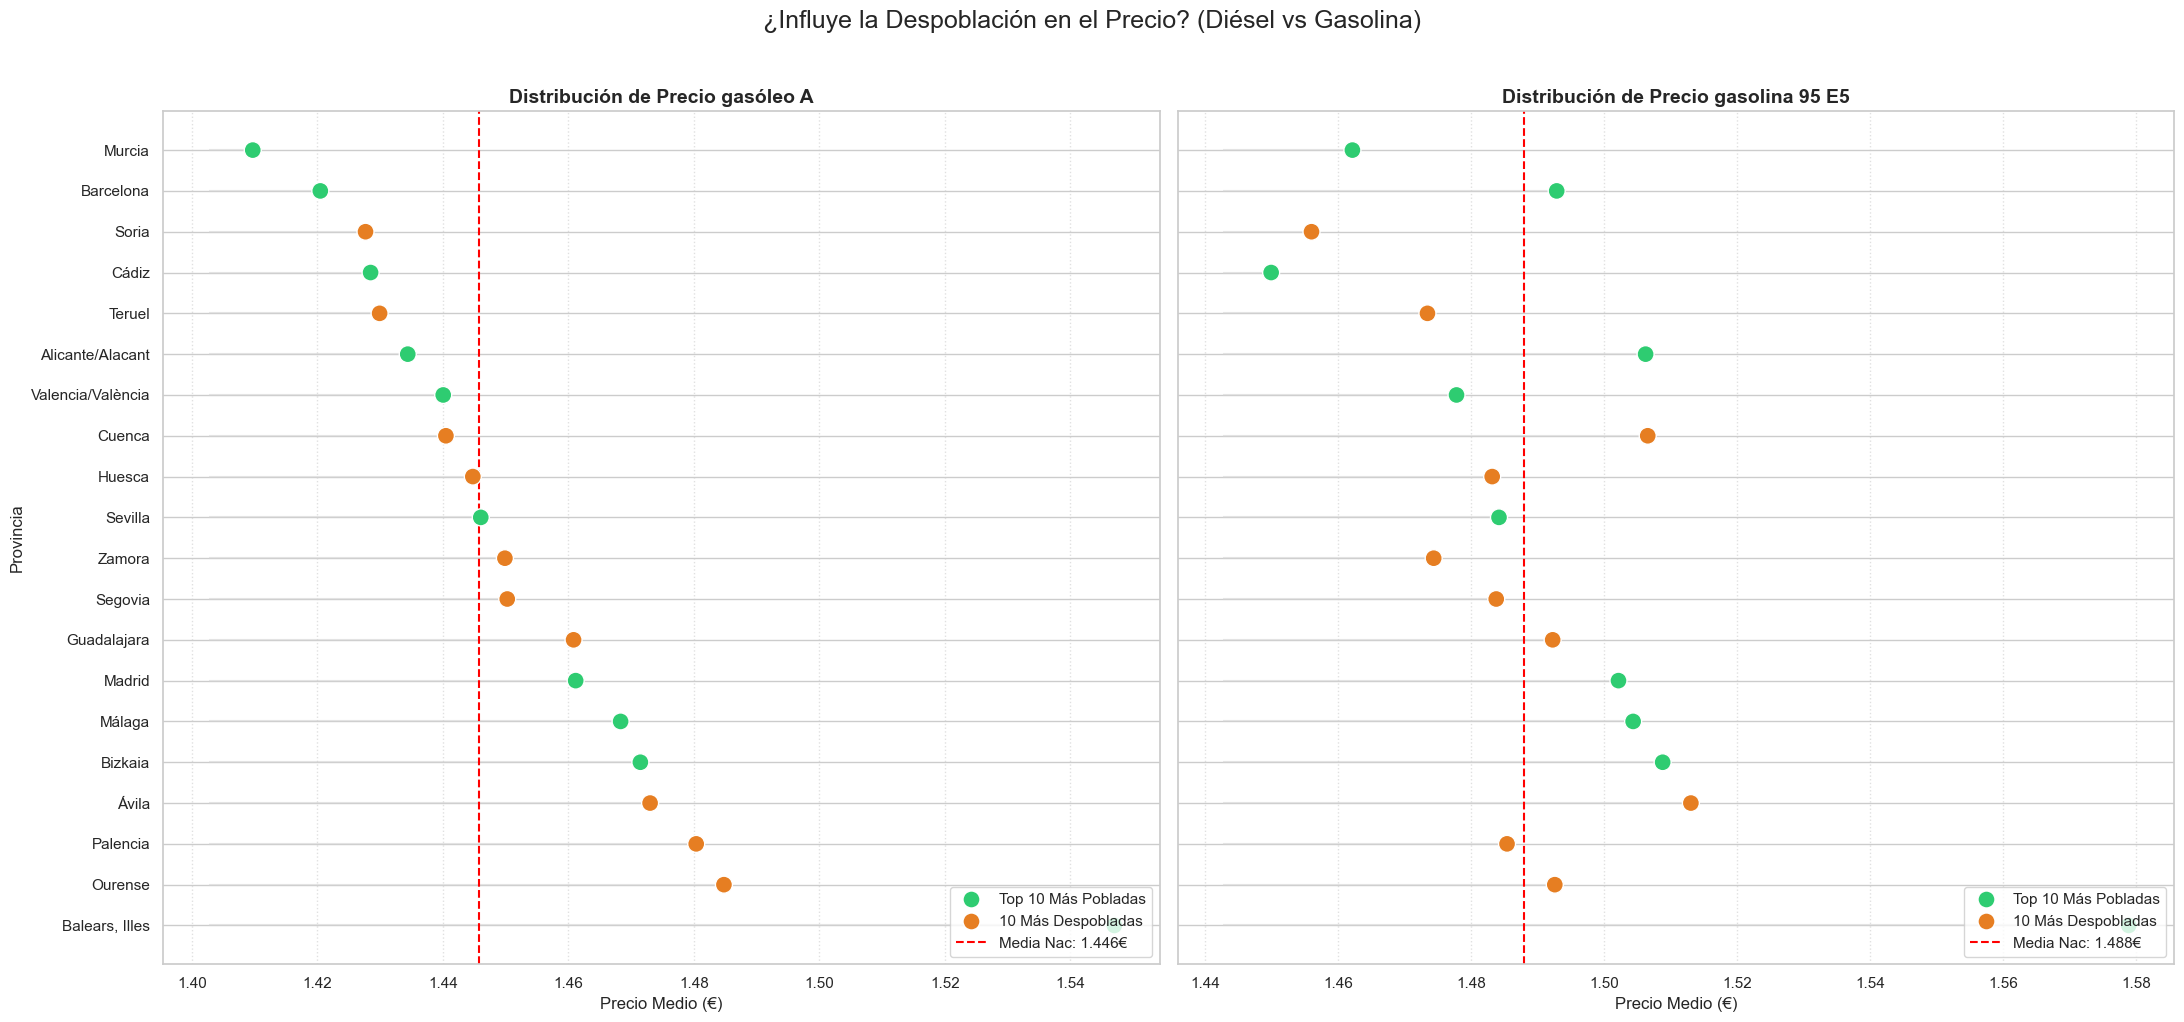

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Preparación y agregación (Diésel + Gasolina)
df_comun = df[df['Regimen_Fiscal_Especial'] == 0].copy()
combustibles = ['Precio gasóleo A', 'Precio gasolina 95 E5']

prov_stats = df_comun.groupby('Provincia').agg({
    'Precio gasóleo A': 'mean',
    'Precio gasolina 95 E5': 'mean',
    'Total población': 'mean'
}).reset_index()

# 2. Selección de los 10 extremos poblacionales
top10 = prov_stats.nlargest(10, 'Total población').copy()
bottom10 = prov_stats.nsmallest(10, 'Total población').copy()

top10['Grupo'] = 'Top 10 Más Pobladas'
bottom10['Grupo'] = '10 Más Despobladas'
df_comp = pd.concat([top10, bottom10])

# 3. Visualización con subplots (Lollipop Chart)
fig, axes = plt.subplots(1, 2, figsize=(22, 10), sharey=True)
colors = {'Top 10 Más Pobladas': '#2ecc71', '10 Más Despobladas': '#e67e22'}

for i, fuel in enumerate(combustibles):
    ax = axes[i]
    df_plot = df_comp.sort_values(fuel) # Ordenamos cada gráfico por su precio
    
    ax.hlines(y=df_plot['Provincia'], xmin=df_plot[fuel].min()*0.995, 
              xmax=df_plot[fuel], color='lightgray', alpha=0.5)
    sns.scatterplot(data=df_plot, x=fuel, y='Provincia', 
                    hue='Grupo', palette=colors, s=150, zorder=3, ax=ax)
    
    # Referencia: Media Nacional del combustible
    avg_fuel = df_comun[fuel].mean()
    ax.axvline(avg_fuel, color='red', linestyle='--', label=f"Media Nac: {avg_fuel:.3f}€")
    
    ax.set_title(f'Distribución de {fuel}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Precio Medio (€)')
    ax.legend(loc='lower right')
    ax.grid(axis='x', linestyle=':', alpha=0.6)

plt.suptitle('¿Influye la Despoblación en el Precio? (Diésel vs Gasolina)', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

### 2.1.3 Disponibilidad de Servicio: Gasolineras por cada 10,000 Habitantes

Vemos en el gráfico circular como las provincias despobladas tienen mayor proporción de gasolineras por habitante, lo que indica un buen dimensionamiento de la red de suministro que trata de dar cobertura a las necesidades de aquellos territorios menos poblados.

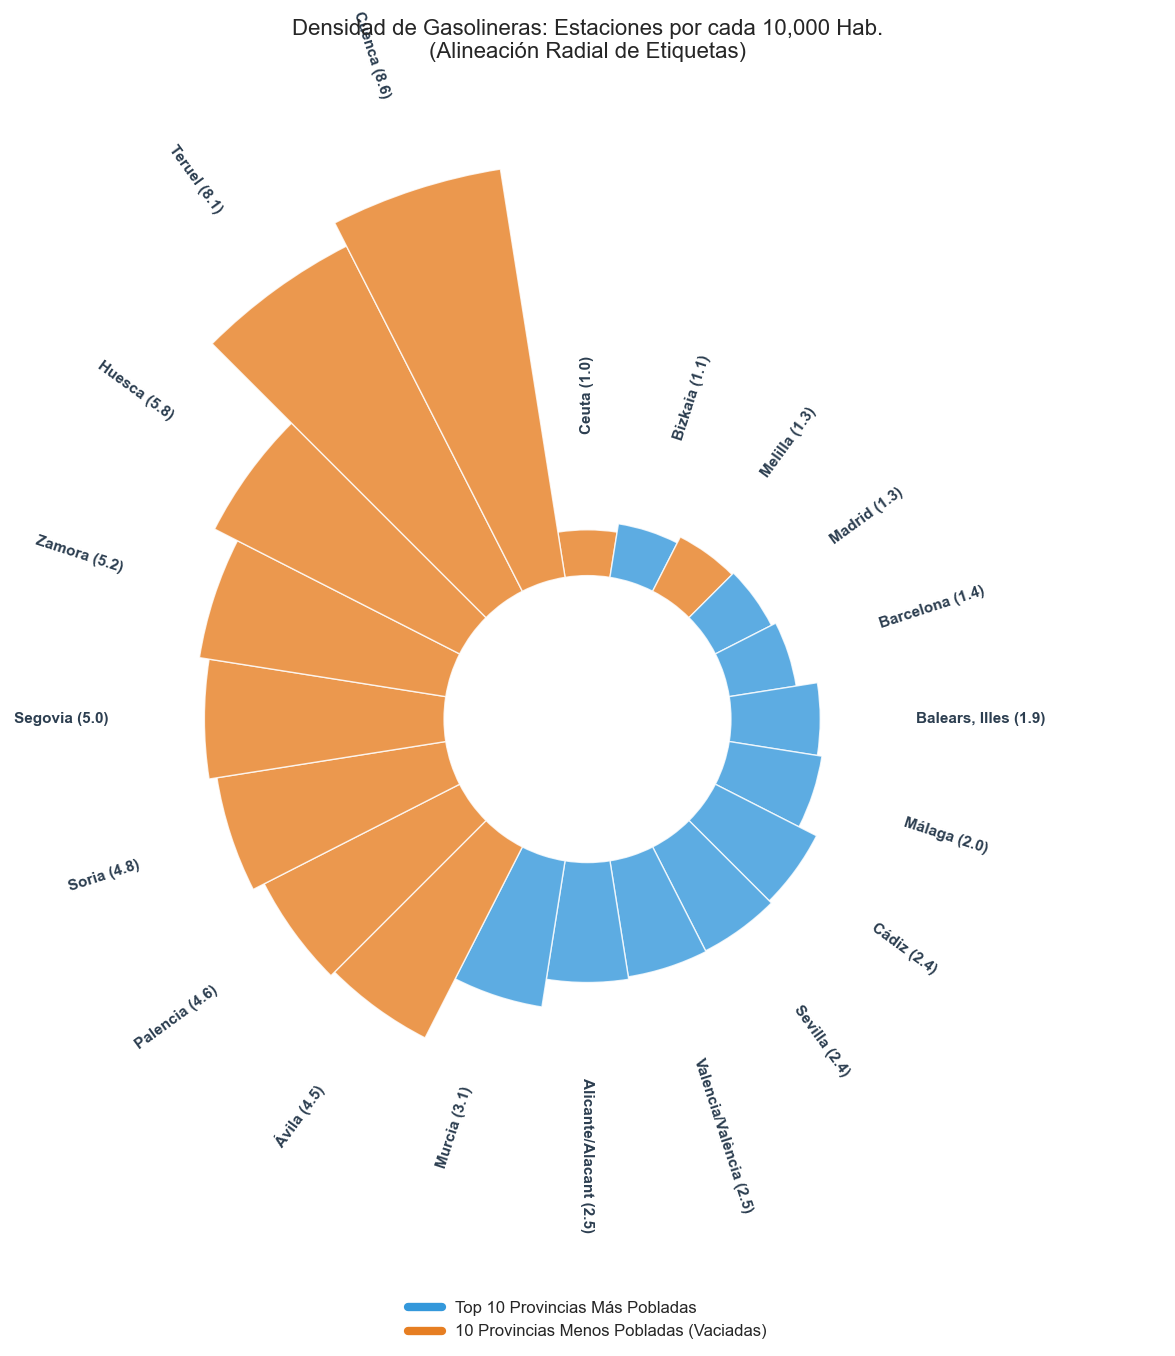

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Preparación de datos (agregación por provincia)
prov_density = df.groupby('Provincia').agg({'Rótulo': 'count', 'Total población': 'mean'}).reset_index()
prov_density['Ratio'] = (prov_density['Rótulo'] / prov_density['Total población']) * 10000

# 2. Selección de los 10 extremos poblacionales
top10 = prov_density.nlargest(10, 'Total población').copy()
bottom10 = prov_density.nsmallest(10, 'Total población').copy()
top10['Grupo'], bottom10['Grupo'] = 'Top 10 pobladas', '10 despobladas'
df_plot = pd.concat([top10, bottom10]).sort_values('Ratio')

# 3. Configuración del Gráfico Polar
N = len(df_plot)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
width = (2 * np.pi) / N

plt.figure(figsize=(15, 15))
ax = plt.subplot(111, polar=True)
colors = ['#3498db' if g == 'Top 10 pobladas' else '#e67e22' for g in df_plot['Grupo']]
ax.bar(angles, df_plot['Ratio'], width=width, color=colors, alpha=0.8, edgecolor='white', bottom=3)

# 4. Etiquetas con ALINEACIÓN RADIAL (Continuando el ángulo de la barra)
for angle, value, prov in zip(angles, df_plot['Ratio'], df_plot['Provincia']):
    # Calculamos la rotación para que siga el radio (ajustando por el offset del gráfico)
    rotation = 90 - np.rad2deg(angle)
    label = f"{prov} ({value:.1f})"
    
    # Lógica de flip: si estamos en la mitad inferior, rotamos 180º para que no esté "boca abajo"
    if angle > np.pi:
        alignment = 'right'
        rotation += 180
    else:
        alignment = 'left'
    
    ax.text(angle, value + 5, label, 
            ha=alignment, va='center', 
            rotation=rotation, rotation_mode='anchor', 
            fontsize=11, fontweight='semibold', color='#2c3e50')

# 5. Formato Final y Leyenda
ax.set_theta_offset(np.pi / 2); ax.set_theta_direction(-1); ax.set_axis_off()
plt.title('Densidad de Gasolineras: Estaciones por cada 10,000 Hab.\n(Alineación Radial de Etiquetas)', fontsize=16, pad=60)

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='#3498db', lw=6, label='Top 10 Provincias Más Pobladas'),
    Line2D([0], [0], color='#e67e22', lw=6, label='10 Provincias Menos Pobladas (Vaciadas)')
]
ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.05), frameon=False, fontsize=12)

plt.show()

## 2.2 Diferencias de precio según distancia a surtidor Exolum más cercano

Observamos como la distancia al suministro EXOLUM -red de suministro español operado por la antigua CHL- no altera significativamente el precio de venta final de los combustibles.

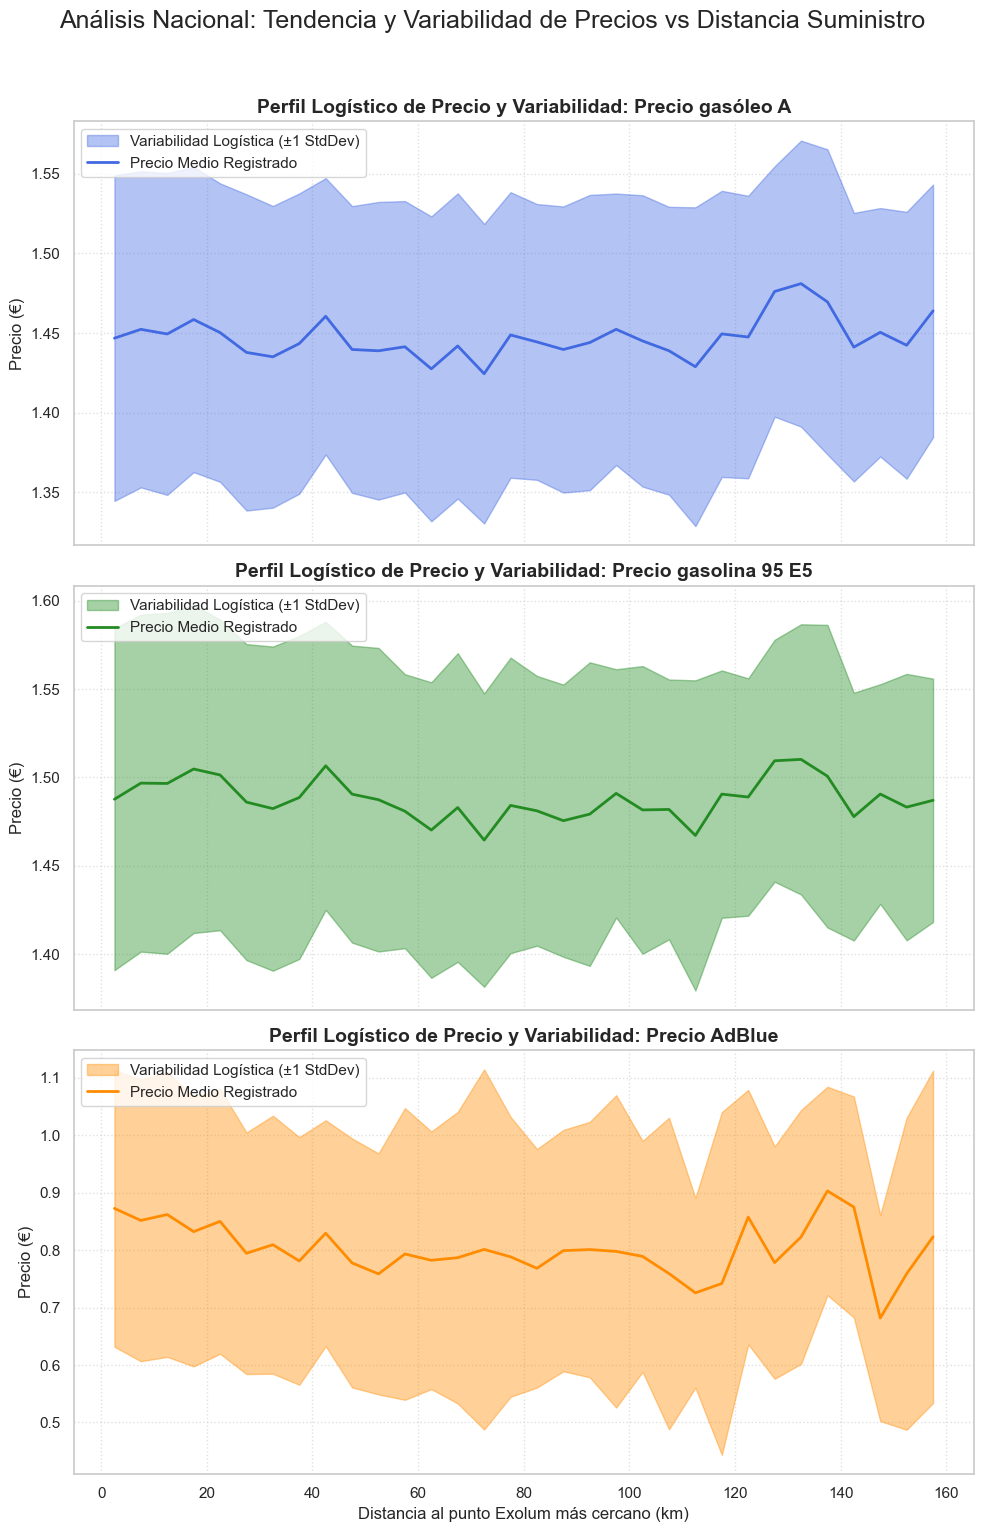

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Filtramos el régimen común (Península y Baleares)
df_comun = df[df['Regimen_Fiscal_Especial'] == 0].copy()

# 2. Configuración de tramos y combustibles
fuels = ['Precio gasóleo A', 'Precio gasolina 95 E5', 'Precio AdBlue']
colores = ['royalblue', 'forestgreen', 'darkorange']
paso = 5 # Tramos de 5km para mayor estabilidad
bins = np.arange(0, 165, paso)

# 3. Creamos la figura con 3 subgráficos
fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

for i, (fuel, color) in enumerate(zip(fuels, colores)):
    # Calculamos media y desviación por cada tramo de distancia
    df_comun['Tramo_Tmp'] = pd.cut(df_comun['Distancia_Exolum_km'], bins=bins)
    stats = df_comun.groupby('Tramo_Tmp', observed=False)[fuel].agg(['mean', 'std']).dropna()
    
    eje_x = [b.mid for b in stats.index]
    media = stats['mean'].values
    variabilidad = stats['std'].values
    
    # Dibujamos el perfil centrado en la media
    # El área sombreada es la media ± 1 desviación típica
    axes[i].fill_between(
        eje_x, 
        media - variabilidad, 
        media + variabilidad, 
        color=color, 
        alpha=0.4, 
        label='Variabilidad Logística (±1 StdDev)'
    )
    
    # Dibujamos la línea de la media para ver la tendencia claramente
    axes[i].plot(eje_x, media, color=color, linewidth=2, label='Precio Medio Registrado')
    
    # Formato individual por gráfico
    axes[i].set_title(f'Perfil Logístico de Precio y Variabilidad: {fuel}', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Precio (€)')
    axes[i].grid(linestyle=':', alpha=0.6)
    axes[i].legend(loc='upper left')

# Formato global del gráfico
plt.xlabel('Distancia al punto Exolum más cercano (km)', fontsize=12)
plt.suptitle('Análisis Nacional: Tendencia y Variabilidad de Precios vs Distancia Suministro', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

## 2.3 Diferencias en el precio según el nivel de competencia

A partir de los datos de competencia, creamos dos visualizaciones:
- Un gráfico de Cordillera -RidgeLine-, que nos muestra la evolución del precio según el nivel de competencia alrededor de cada punto de venta.
- Un gráfico stripplot, tambien llamado gráfico de violín, que nos muestra la relación entre el precio y el nivel de competencia.

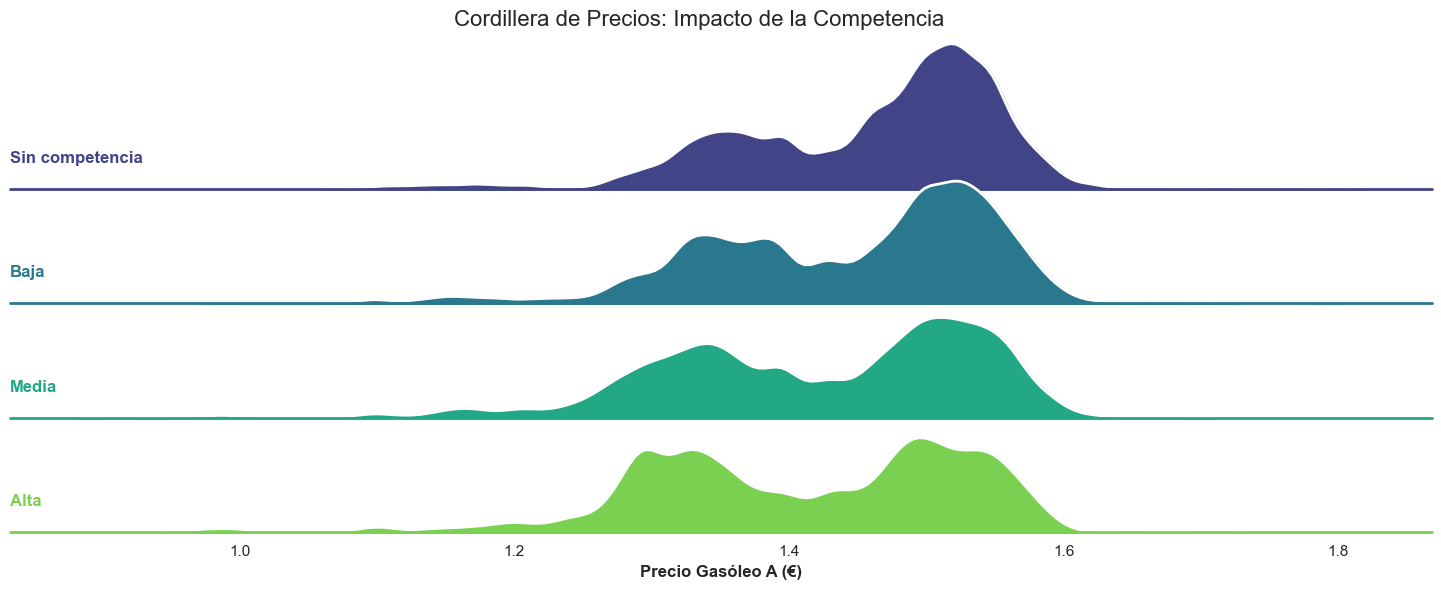

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Estilo para el efecto "Ridgeline" (fondo transparente en los ejes)
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# 2. Definimos el orden y la paleta de colores
orden = ['Sin competencia', 'Baja', 'Media', 'Alta']
paleta = sns.color_palette("viridis", n_colors=4)

# 3. Creamos el FacetGrid para apilar los gráficos
g = sns.FacetGrid(
    df, 
    row="Nivel_Competencia", 
    hue="Nivel_Competencia", 
    aspect=10, 
    height=1.5, 
    palette=paleta,
    row_order=orden
)

# 4. Dibujamos las densidades (KDE) rellenas y sus contornos blancos
g.map(sns.kdeplot, "Precio gasóleo A", bw_adjust=.5, clip_on=False, fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "Precio gasóleo A", clip_on=False, color="white", lw=2, bw_adjust=.5)

# 5. Añadimos la línea base para dar estructura de "montaña"
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# 6. Función para añadir etiquetas personalizadas a cada fila
def label_ridgeline(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes, fontsize=12)

g.map(label_ridgeline, "Precio gasóleo A")

# 7. Limpieza estética (eliminamos etiquetas repetitivas y ajustamos solapamiento)
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

plt.xlabel('Precio Gasóleo A (€)', fontsize=12, fontweight='bold')
plt.suptitle('Cordillera de Precios: Impacto de la Competencia', fontsize=16, y=0.98)
g.fig.subplots_adjust(hspace=-.25) # El solapamiento negativo crea el efecto visual

plt.show()

C:\Users\Pedro\AppData\Local\Temp\ipykernel_25116\2081478089.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(


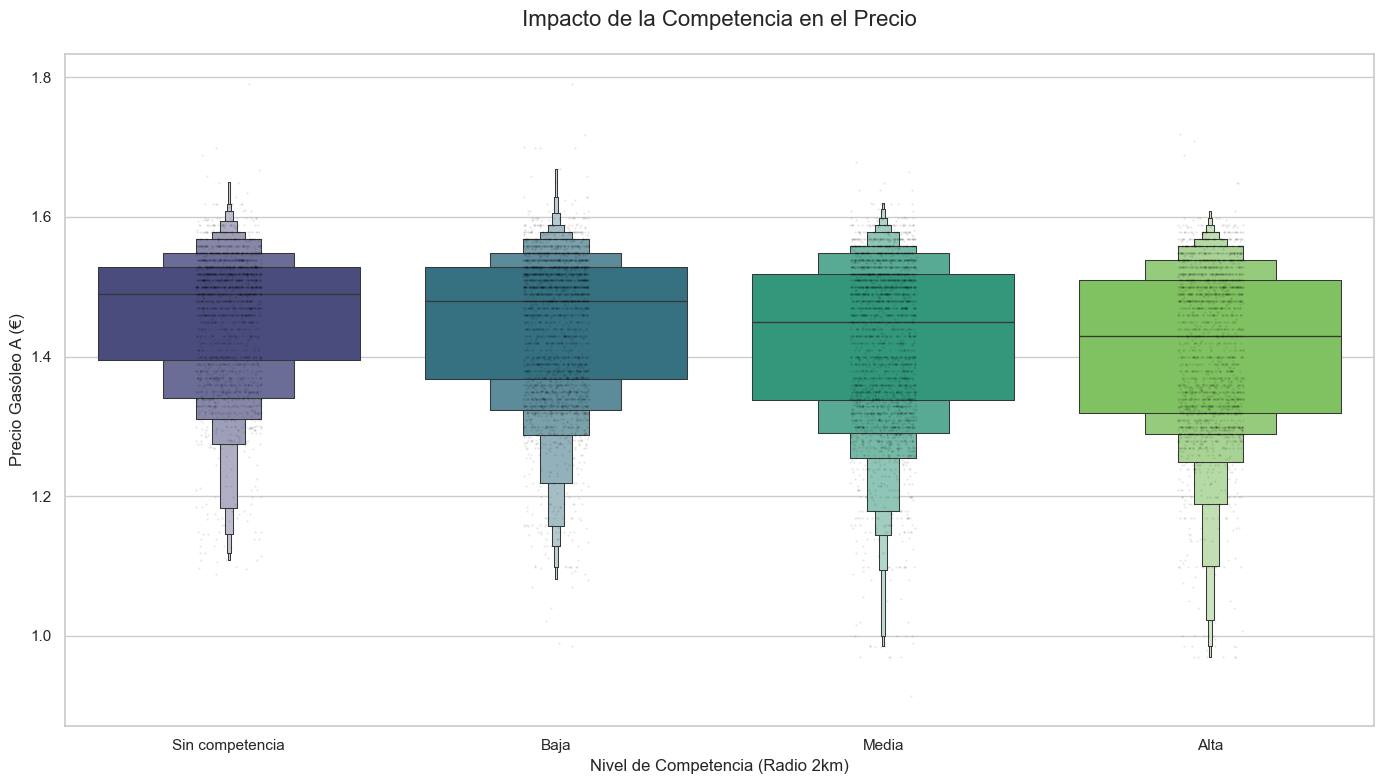

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Configuramos el estilo
sns.set_theme(style="whitegrid")

# 2. Creamos la figura
plt.figure(figsize=(14, 8))

# 3. Dibujamos el Boxen Plot (Representación avanzada de la distribución)
orden = ['Sin competencia', 'Baja', 'Media', 'Alta']
sns.boxenplot(
    data=df, 
    x='Nivel_Competencia', 
    y='Precio gasóleo A', 
    palette='viridis',
    order=orden,
    showfliers=False # Ocultamos outliers extremos para que el gráfico sea más legible
)

# 4. Añadimos el "efecto lluvia" (puntos individuales) muy sutilmente
sns.stripplot(
    data=df, 
    x='Nivel_Competencia', 
    y='Precio gasóleo A', 
    size=1.5, 
    color="black", 
    alpha=0.1, 
    jitter=True,
    order=orden
)

# 5. Formato
plt.title('Impacto de la Competencia en el Precio', fontsize=16, pad=20)
plt.ylabel('Precio Gasóleo A (€)', fontsize=12)
plt.xlabel('Nivel de Competencia (Radio 2km)', fontsize=12)

plt.tight_layout()
plt.show()

## 2.4 Diferencias de precio según el regimen fiscal

Utilizamos un gráfico de pendiente para representar la diferencia de precios entre los diferentes regímenes fiscales.

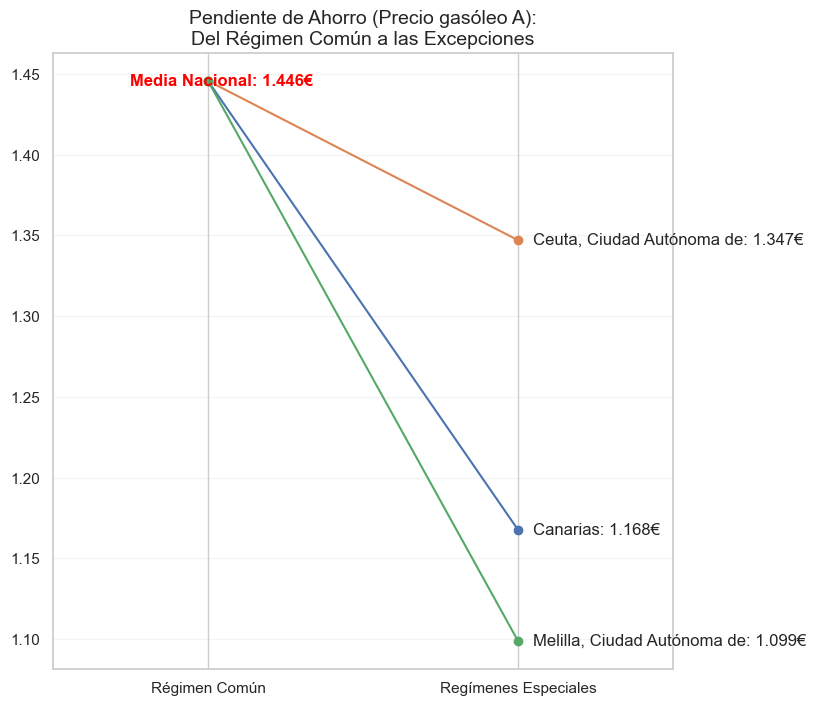

In [23]:
import matplotlib.pyplot as plt

# 0. Preparación de datos (Definición de Variables Clave)
fuel = 'Precio gasóleo A'

# Definimos el Benchmark: Precio medio del Régimen Común (Península y Baleares)
benchmark = df[df['Regimen_Fiscal_Especial'] == 0][fuel].mean()

# Definimos las Regiones Especiales: Precio medio por cada comunidad con régimen especial
regiones_especiales = df[df['Regimen_Fiscal_Especial'] == 1].groupby('Comunidad_Autonoma')[fuel].mean()

# 1. Preparamos los puntos para el gráfico
x_labels = ['Régimen Común', 'Regímenes Especiales']
y_mainland = [benchmark] * len(regiones_especiales)
y_regions = regiones_especiales.values

# 2. Dibujamos las líneas de "caída"
plt.figure(figsize=(8, 8))

for i, region in enumerate(regiones_especiales.index):
    plt.plot(x_labels, [benchmark, y_regions[i]], marker='o', label=region)
    plt.text(1.05, y_regions[i], f"{region}: {y_regions[i]:.3f}€", va='center')

plt.text(-0.25, benchmark, f"Media Nacional: {benchmark:.3f}€", va='center', fontweight='bold', color='red')

# 3. Formato
plt.title(f'Pendiente de Ahorro ({fuel}):\nDel Régimen Común a las Excepciones', fontsize=14)
plt.xticks([0, 1], x_labels)
plt.xlim(-0.5, 1.5)
plt.grid(axis='y', alpha=0.2)
plt.show()

## 2.5 Diferencias según el tipo de vendedor
Dividimos a los vendedores por cuatro tipos:
- Petroleras convencionales.
- Supermercados.
- Low cost.
- Independientes.

Observamos el importante salto de precio que existe entre los diferentes vendedores.

C:\Users\Pedro\AppData\Local\Temp\ipykernel_25988\2528319371.py:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Pedro\AppData\Local\Temp\ipykernel_25988\2528319371.py:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




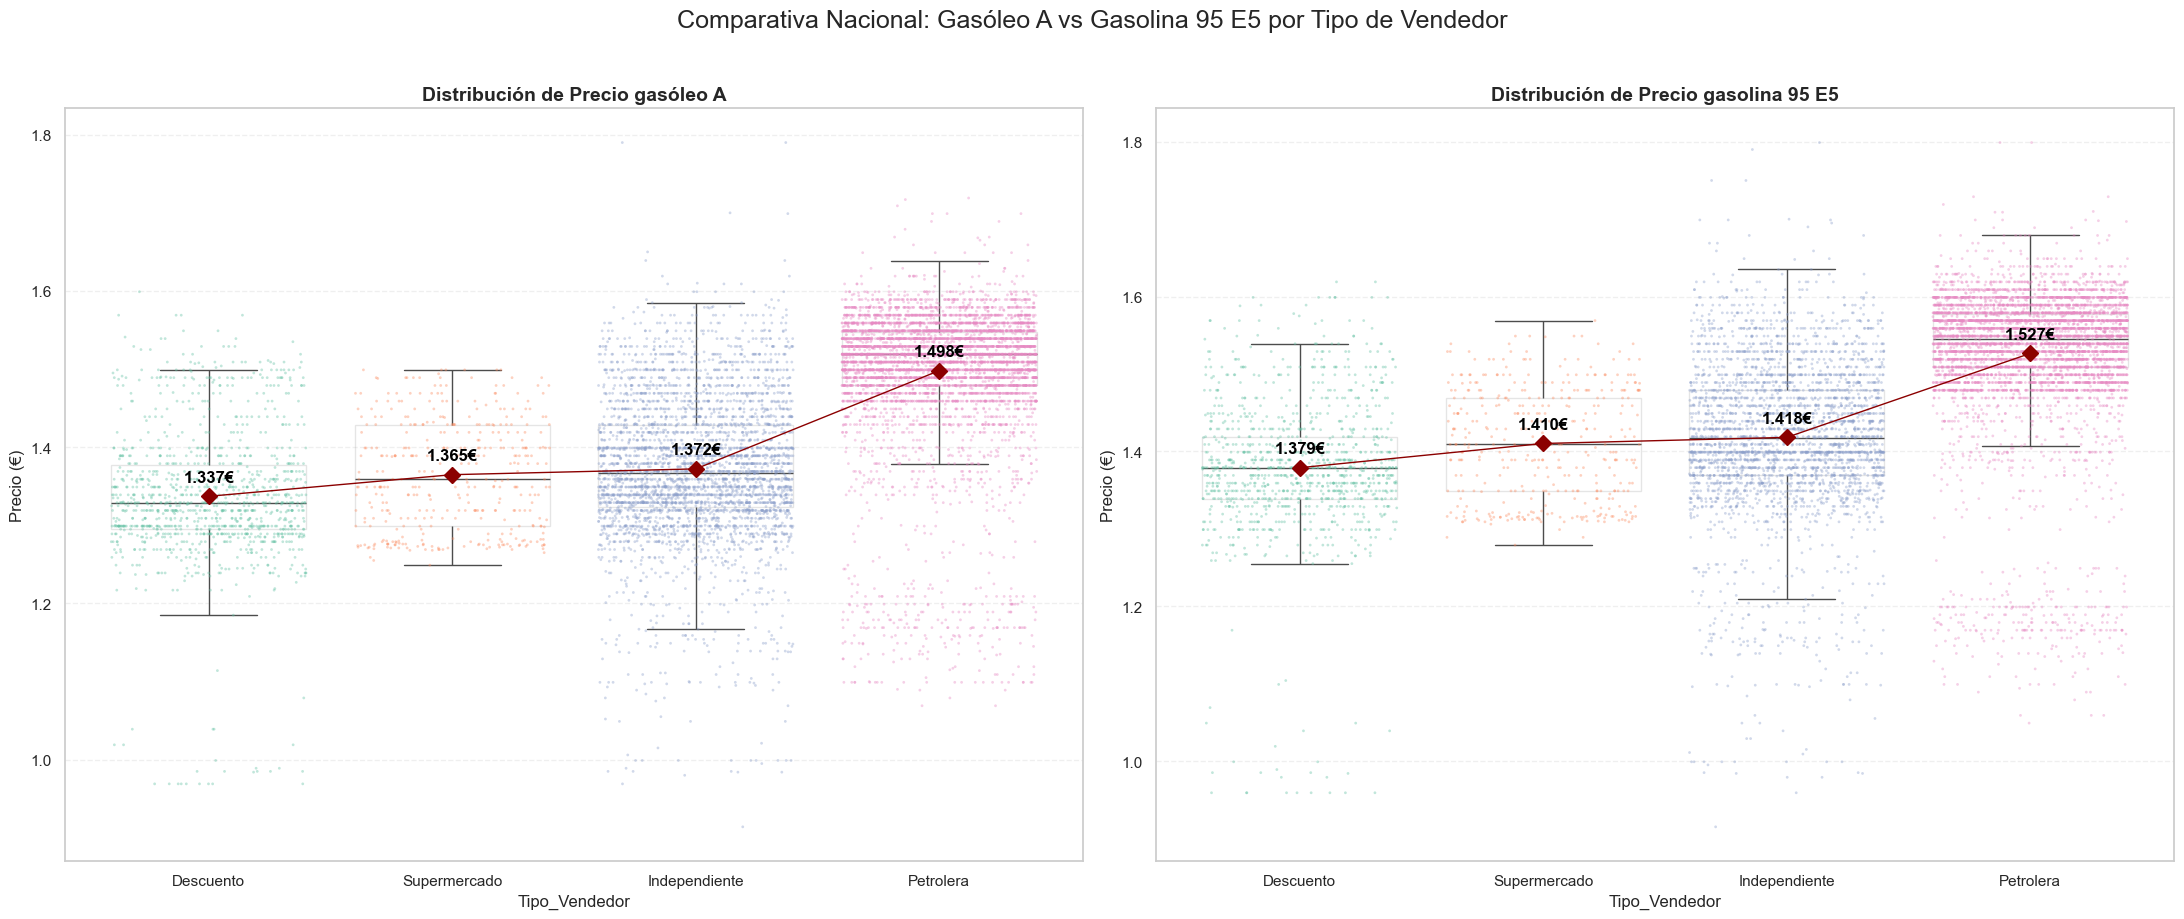

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Configuración de combustibles y orden (usamos Tipo_Vendedor)
combustibles = ['Precio gasóleo A', 'Precio gasolina 95 E5']
orden = ['Descuento', 'Supermercado', 'Independiente', 'Petrolera']

# 2. Creamos la figura con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(22, 9))

for i, fuel in enumerate(combustibles):
    ax = axes[i]
    
    # Cálculo de medias por segmento
    stats = df.groupby('Tipo_Vendedor')[fuel].mean().reindex(orden)
    
    # Fondo: Boxplot sutil
    sns.boxplot(data=df, x='Tipo_Vendedor', y=fuel, order=orden, ax=ax,
                showfliers=False, boxprops={'facecolor':'None', 'edgecolor':'gray', 'alpha':0.2})

    # Enjambre de puntos
    sns.stripplot(data=df, x='Tipo_Vendedor', y=fuel, order=orden, ax=ax,
                  jitter=0.4, size=2, alpha=0.4, palette='Set2')

    # Línea de tendencia media (fina: linewidth=1)
    ax.plot(range(len(orden)), stats.values, color='darkred', 
            marker='D', markersize=8, linewidth=1, label='Precio Medio', zorder=5)

    # Etiquetas con el valor en cada punto medio
    for idx, m in enumerate(stats.values):
        ax.text(idx, m + 0.015, f"{m:.3f}€", ha='center', va='bottom', 
                fontweight='bold', color='black', fontsize=12)

    ax.set_title(f'Distribución de {fuel}', fontsize=14, fontweight='bold')
    ax.set_ylabel('Precio (€)')
    ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.suptitle('Comparativa Nacional: Gasóleo A vs Gasolina 95 E5 por Tipo de Vendedor', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

# Conclusiones del Análisis de Precios de Carburantes en España

Tras el desarrollo de las diferentes visualizaciones avanzadas, se extraen las siguientes conclusiones principales:

### 1. Efecto de la densidad de población en el precio y la disponibilidad
El análisis revela que **no existen diferencias significativas** en los precios de los carburantes entre las zonas de alta y baja densidad poblacional. Sorprendentemente, los municipios con menor población tienden a presentar una **mayor disponibilidad de estaciones de servicio por habitante**, lo que garantiza el suministro en áreas rurales. En términos de coste, los precios medios en estas zonas menos pobladas **no difieren sustancialmente** de los observados en grandes núcleos urbanos, lo que sugiere que la densidad demográfica no es un factor determinante en el encarecimiento del combustible.

### 2. Efecto de la Logística (Distancia a Exolum)
Existe una **correlación muy escasa** entre la distancia a los centros de distribución de Exolum y el precio final de venta. A medida que las estaciones se alejan de estos puntos clave el precio medio varia de manera errática sin aumentar la variabilidad de precios.
Vemos pues, que la distancia al punto de suministro EXOLUM afecta de manera mínima al precio de venta al consumidor final.

### 3. Impacto de la Competencia
La competencia actúa como el principal **motor de precios bajos**. Las zonas con alta densidad de estaciones (radio de 2km) presentan precios significativamente más contenidos y menos dispersos. Por el contrario, las zonas "aisladas" o sin competencia permiten una mayor libertad de márgenes y precios medios superiores.

### 4. Segmentación por Tipo de Vendedor
El análisis de enjambre confirma una jerarquía comercial muy definida:
*   **Descuento y Supermercado**: Son los líderes en precios bajos, con nubes de puntos muy concentradas en la banda inferior.
*   **Tradicionales (Petroleras)**: Mantienen los precios más altos del mercado de manera consistente en todas las comunidades autónomas.

### 5. Brecha Fiscal Regional
La fiscalidad es el factor de mayor peso unitario. El **Régimen Común** (Península y Baleares) opera en un escalón de precios totalmente diferente al de las regiones con **Regímenes Especiales** (Canarias, Ceuta y Melilla), donde el ahorro por impuestos es superior a cualquier ahorro que se pueda conseguir por competencia o logística.

### 6. Dinámica Multicombustible
Los patrones de comportamiento comercial son **simétricos** entre el Gasóleo A y la Gasolina 95 E5. Aunque los precios base son distintos, las subidas y bajadas medias según el tipo de vendedor o la competencia siguen trayectorias paralelas, lo que indica políticas de precios corporativas aplicadas a todo el inventario de la estación.